In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from src.file_locations import intermediate_files_location

print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.7.2
umap version: 0.5.9.post2


In [3]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"
training = "first_mixed_del1g_iso_training"

sig_category_name = "del1g_simple_signal_category"

if sig_category_name == "del1g_simple_signal_category":
    sig_categories = del1g_simple_category_labels
    sig_colors = del1g_simple_category_colors
elif sig_category_name == "del1g_detailed_signal_category":
    sig_categories = del1g_detailed_category_labels
    sig_colors = del1g_detailed_category_colors
elif sig_category_name == "topological_signal_category":
    sig_categories = topological_category_labels
    sig_colors = topological_category_colors
else:
    raise ValueError(f"Invalid sig_category_name: {sig_category_name}")


# File Loading

In [4]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(2226353, 242)
loading predictions.pkl...
pred_df.shape=(375264, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(187632, 260)
presel_merged_df.shape=(187632, 260)


,wc_nc_pio_score,wc_single_photon_numu_score,wc_shw_sp_n_20br1_showers,wc_WCPMTInfoTPCClusterID,wc_shw_sp_n_20mev_showers,wc_nc_delta_score,wc_WCPMTInfoClusterLength,wc_WCPMTInfoKSDistance,wc_WCPMTInfoNDF,wc_WCPMTInfoChi2,...,prob_NC1pi0_0p,prob_numuCC1pi0_Np,prob_numuCC1pi0_0p,prob_1pi0_outFV,prob_nueCC_Np,prob_nueCC_0p,prob_multi_pi0,prob_0pi0,prob_other_outFV_dirt,prob_ext
7,-1.320506,-2.101542,0.0,NaN,1.0,-3.831858,NaN,NaN,NaN,NaN,...,0.006109,0.001604,0.000696,0.034453,0.000254,0.000197,0.000290,0.045996,0.112361,0.310072
21,-3.169012,-1.800440,2.0,NaN,2.0,-2.425649,NaN,NaN,NaN,NaN,...,0.002230,0.003393,0.000379,0.002650,0.000151,0.000123,0.000213,0.328072,0.015634,0.052423
60,-2.242356,-3.624760,2.0,NaN,2.0,-7.060031,NaN,NaN,NaN,NaN,...,0.000248,0.023989,0.002379,0.000237,0.000120,0.000080,0.000183,0.901691,0.002164,0.001698
71,-3.127084,-2.554086,1.0,NaN,1.0,-7.687320,NaN,NaN,NaN,NaN,...,0.000783,0.025430,0.002940,0.001229,0.000336,0.000117,0.000307,0.731885,0.001961,0.002983
83,-3.721158,-4.104197,0.0,NaN,1.0,-7.675740,NaN,NaN,NaN,NaN,...,0.000513,0.001059,0.000248,0.001046,0.000054,0.000036,0.000093,0.960735,0.021938,0.003839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226326,0.516163,1.732724,1.0,25.0,1.0,-0.241512,54.332122,0.029771,31.0,103.130792,...,0.000503,0.000335,0.000100,0.000943,0.000042,0.000033,0.000044,0.000760,0.002635,0.003762
2226327,-0.348850,0.985891,1.0,38.0,1.0,3.958367,62.667732,0.075140,31.0,29.134948,...,0.000323,0.000261,0.000097,0.000188,0.000044,0.000034,0.000046,0.000232,0.000180,0.000173
2226343,-1.176651,1.502878,2.0,47.0,2.0,-2.645450,27.363369,0.050947,31.0,7.910047,...,0.002197,0.000285,0.000137,0.003208,0.000071,0.000126,0.000150,0.000800,0.000507,0.000793
2226350,0.831495,0.928880,1.0,39.0,1.0,-3.027475,88.766007,0.049299,31.0,103.542597,...,0.000777,0.000574,0.000230,0.000128,0.001456,0.000142,0.000134,0.000493,0.000686,0.000254


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [6]:
#scaler = StandardScaler()
#probs_scaled = scaler.fit_transform(probs_2d_arr)
probs_scaled = probs_2d_arr

reducer = umap.UMAP(random_state=42)

reducer.fit(probs_scaled)
umap_result = reducer.transform(probs_scaled)


/nevis/houston/home/leehagaman/uv_base/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


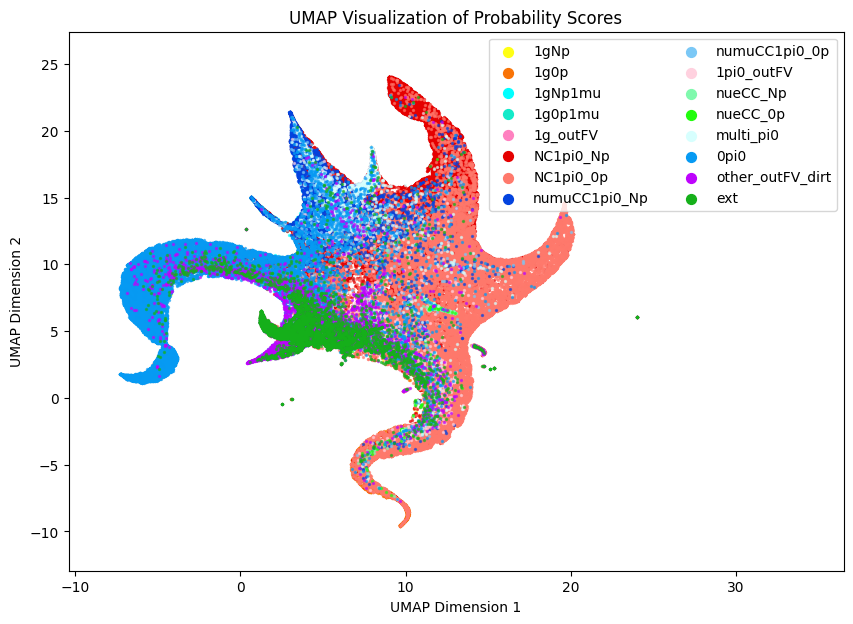

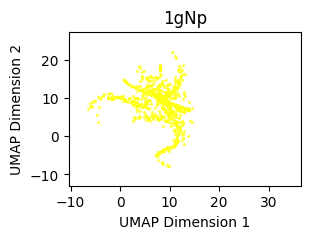

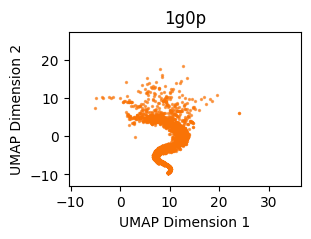

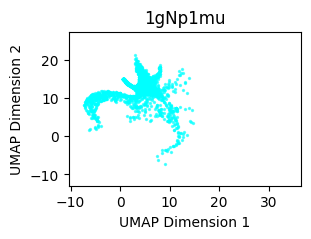

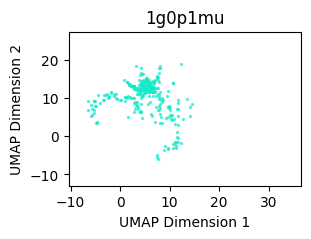

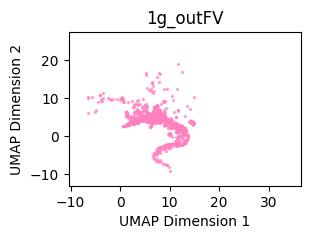

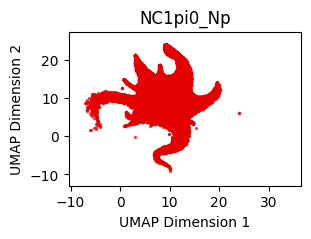

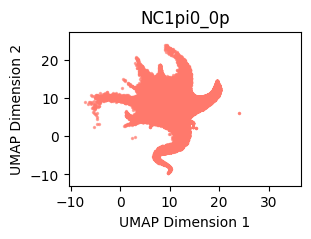

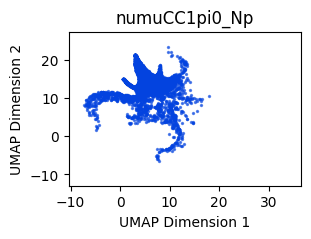

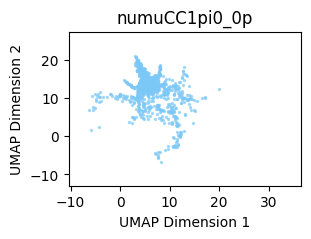

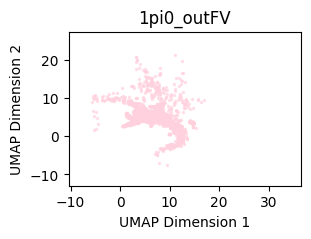

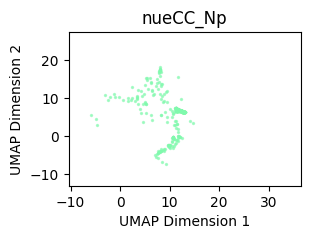

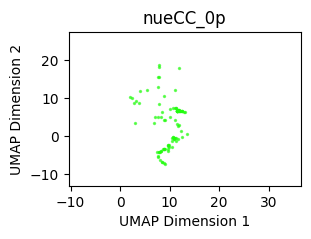

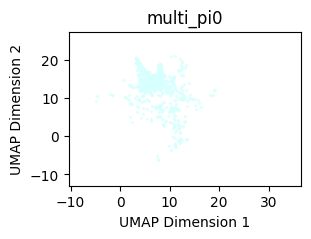

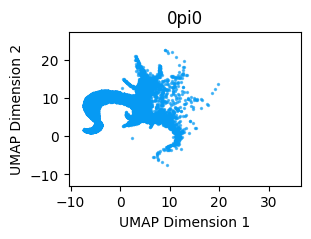

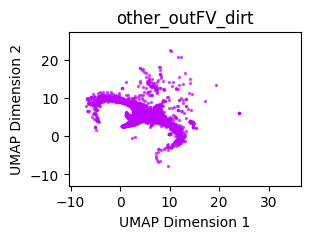

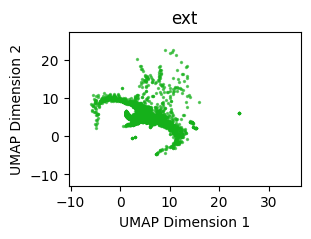

In [7]:
true_sig_categories = presel_merged_df[sig_category_name].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/umap_visualization.png")

for i in range(len(sig_categories)):
    plt.figure(figsize=(3, 2))
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
    plt.title(sig_categories[i])
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
    min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
    x_diff = max_x - min_x
    y_diff = max_y - min_y
    plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
    plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
    plt.savefig(f"../training_outputs/{training}/score_vis/{sig_categories[i]}_umap_visualization.png")
